In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils

# Data Loading

In [2]:
data = np.load('data.npz')
x, y = data['x'], data['y']
x = np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)
t = np.arange(-1, 1, 0.01).reshape((-1, 1))
t = np.concatenate([np.ones((t.shape[0], 1)), t], axis=1)

In [3]:
x_small, y_small = x[:15], y[:15]

Ex1 Build a scatter plot for x_small, y_small. You may want to look at plt.scatter

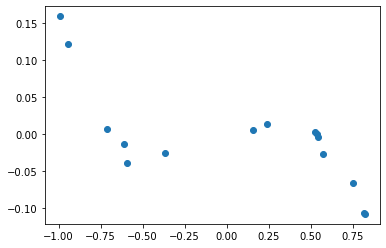

In [4]:
plt.scatter(x_small[:, 1], y_small)

## Simple Linear Regression

Ex2 Fit a simple linear regression with lr=0.05 and plot the evolution of losses. You may want to look at utils file and at plt.plot

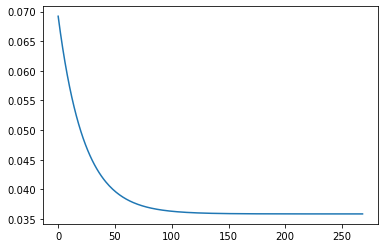

In [5]:
opt = utils.GD(0.05)
lr = utils.LR(num_features=2, optimizer=opt)
losses = lr.fit(x_small, y_small)
plt.plot(losses)

Ex3 Calculate model predictions over the values of t and plot them together with the input data

In [6]:
y_pred = lr.predict(t)

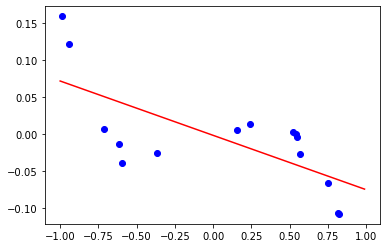

In [7]:
plt.scatter(x_small[:, 1], y_small, color='blue')
plt.plot(t[:, 1], y_pred, color='red')

## Polynomial Regression

Ex4 Define a function which takes a matrix x (first column is constant 1), int deg and returns matrix x_poly which has first column as constant 1 and other columns
are initial columns to the powers k, k=1..deg.

In [8]:
def make_poly(x, deg):
    x_poly = x[:, 1:]
    #polys = []
    for k in range(2, deg+1):
        x_poly = np.concatenate([x_poly, x[:, 1:] ** k], axis=1)
    
    x_poly = np.concatenate([np.ones((x.shape[0], 1)), x_poly], axis=1)
    return x_poly

In [9]:
def make_funcs(x, funcs):
    x_poly = x[:, 1:]
    #polys = []
    for f in funcs:
        x_poly = np.concatenate([x_poly, f(x[:, 1:])], axis=1)
    
    x_poly = np.concatenate([np.ones((x.shape[0], 1)), x_poly], axis=1)
    return x_poly

In [10]:
x_test = np.array([
    [1, 2, 3],
    [1, 4, 5]])
y_res = np.array([[  1.,   2.,   3.,   4.,   9.,   8.,  27.],
                  [  1.,   4.,   5.,  16.,  25.,  64., 125.]])

In [11]:
make_poly(x_test, 4)

array([[  1.,   2.,   3.,   4.,   9.,   8.,  27.,  16.,  81.],
       [  1.,   4.,   5.,  16.,  25.,  64., 125., 256., 625.]])

In [12]:
assert np.allclose(make_poly(x_test, 3), y_res), print('Something is wrong')

Ex5 Build polynomial regressions for all degrees from 1 to 25 and store their losses. For this exercise use fit_closed_form method instead of GD

In [13]:
lrs = {'models': [], 'losses': []}
for k in range(1, 26):
    x_poly_k = make_poly(x_small, k)
    lrs['models'].append(utils.LR(num_features=x_poly_k.shape[1]))
    loss = lrs['models'][-1].fit_closed_form(x_poly_k, y_small)
    lrs['losses'].append(loss)
    

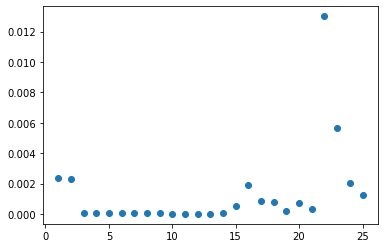

In [14]:
plt.scatter(list(range(1, 26)), lrs['losses'])

Ex6 plot the predicted values over t and scatter of true points for some models

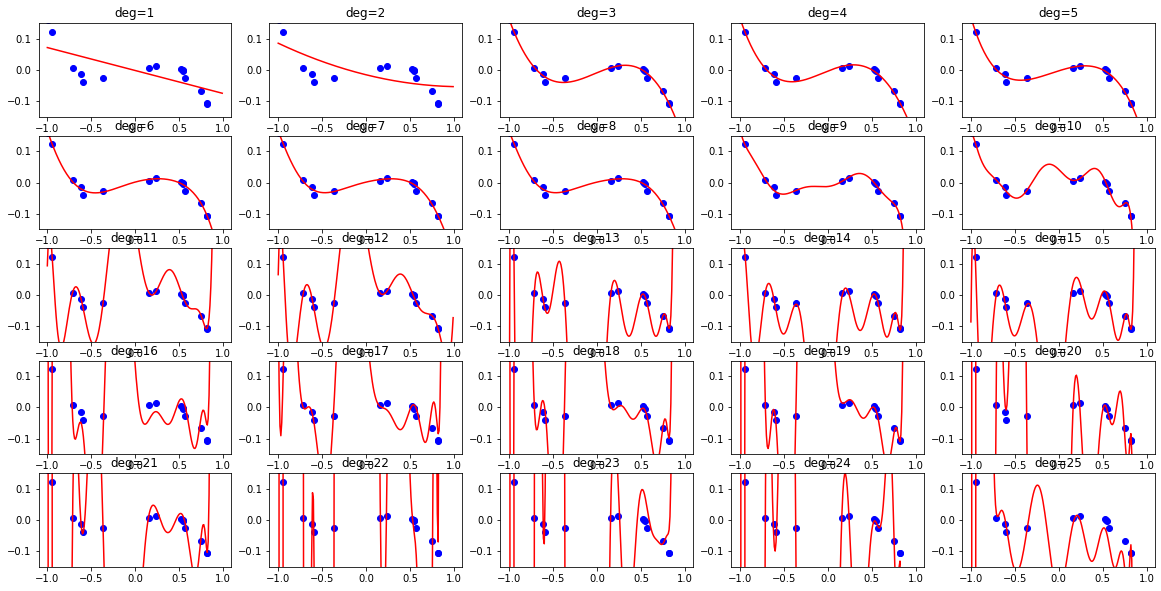

In [15]:
plt.figure(figsize=(20, 10))
for k in range(1, 26):

    t_poly = make_poly(t, k)
    lr = lrs['models'][k-1]
    y_pred = lr.predict(t_poly)
    plt.subplot(5, 5, k)
    plt.scatter(x_small[:, 1], y_small, color='blue')
    plt.plot(t[:, 1], y_pred, color='red')
    plt.ylim((-0.15, 0.15))
    plt.title(f'deg={k}')
plt.show()

## Overfit/Underfit

Ex7 Modify the regression's fit method to also get some validation data and output losses over validation data

In [16]:
class LR_valid:
    def __init__(self, num_features=1, optimizer=utils.GD(0.1)):
        self.W = np.zeros((num_features, 1))
        self.optimizer = optimizer
    
    def predict(self, X):
        y = X @ self.W
        return y
    
    def one_step_opt(self, X, y_true):
        grads = - X.T @ (y_true - X @ self.W) / X.shape[0]
        self.W = self.optimizer.apply_grads(self.W, grads)
        loss = (y_true - self.predict(X)).T @ (y_true - self.predict(X)) / X.shape[0]
        return loss, grads
    
    def fit(self, X, y_true, X_valid=None, y_valid=None, grad_tol=0.0001, n_iters=1000):
        grad_norm = np.inf
        n_iter = 0
        losses = []
        valid_losses = []
        while (grad_norm > grad_tol) and (n_iter < n_iters):
            loss, grads = self.one_step_opt(X, y_true)
            grad_norm = np.linalg.norm(grads)
            n_iter += 1
            losses.append(loss[0][0])
            valid_loss = (y_valid - self.predict(X_valid)).T @ (y_valid - self.predict(X_valid)) / X_valid.shape[0]
            valid_losses.append(valid_loss[0][0])
        return losses, valid_losses
    
    def fit_closed_form(self, X, y_true, X_valid=None, y_valid=None):
        self.W = np.linalg.inv(X.T @ X) @ X.T @ y_true
        loss = (y_true - self.predict(X)).T @ (y_true - self.predict(X)) / X.shape[0]
        return loss

In [17]:
k = 3
x_poly = make_poly(x_small, k)
x_valid = make_poly(x[100:1100], k)
y_valid = y[100:1100]
lr = LR_valid(num_features=x_poly.shape[1])
losses, valid_losses = lr.fit(x_poly, y_small, X_valid=x_valid, y_valid=y_valid)

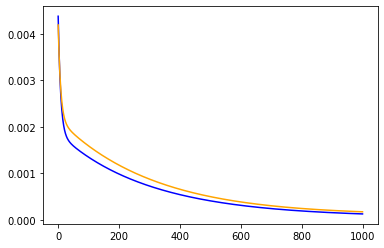

In [18]:
plt.plot(losses, color='blue')
plt.plot(valid_losses, color='orange')

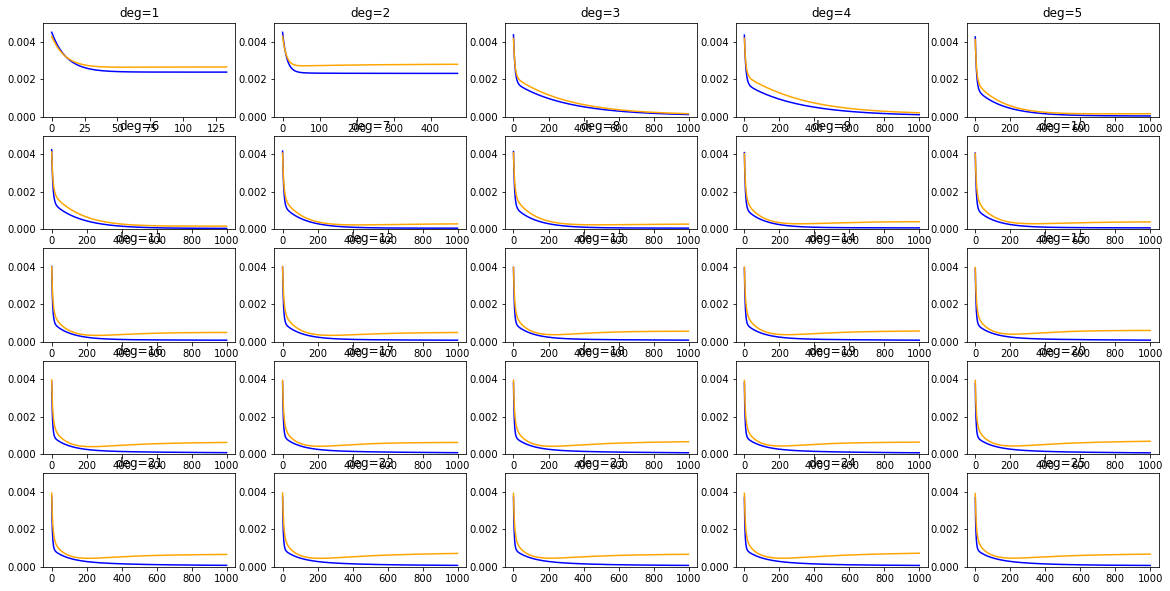

In [19]:
plt.figure(figsize=(20, 10))
for k in range(1, 26):
    
    x_poly = make_poly(x_small, k)
    x_valid = make_poly(x[100:1100], k)
    y_valid = y[100:1100]
    lr = LR_valid(num_features=x_poly.shape[1])
    losses, valid_losses = lr.fit(x_poly, y_small, X_valid=x_valid, y_valid=y_valid)
    plt.subplot(5, 5, k)
    plt.plot(losses, color='blue')
    plt.plot(valid_losses, color='orange')
    plt.ylim((0, 0.005))
    plt.title(f'deg={k}')
plt.show()

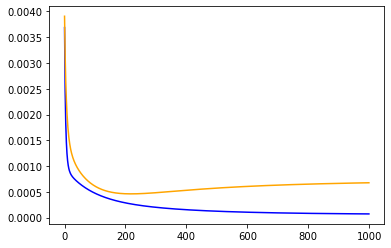

In [20]:
plt.plot(losses, color='blue')
plt.plot(valid_losses, color='orange')

In [21]:
k = 12
x_poly = make_poly(x[:8000], k)
x_valid = make_poly(x[8000:], k)
y_valid = y[8000:]
lr = LR_valid(num_features=x_poly.shape[1])
losses, valid_losses = lr.fit(x_poly, y[:8000], X_valid=x_valid, y_valid=y_valid)

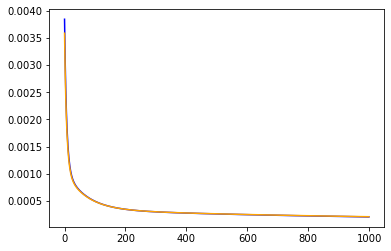

In [22]:
plt.plot(losses, color='blue')
plt.plot(valid_losses, color='orange')

In [23]:
t_poly = make_poly(t, k)
y_pred = lr.predict(t_poly)

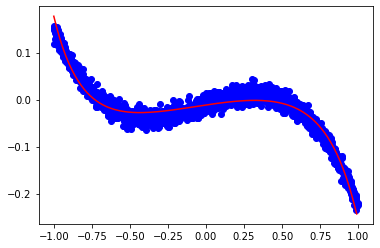

In [24]:
plt.plot(t[:, 1], y_pred, color='red')
plt.scatter(x[8000:, 1], y[8000:], color='blue')

Ex8 Find train and valid losses for all polynomial models

In [25]:
lrs = {'models': [], 'losses': [], 'train_loss_history': [], 'valid_loss_history': []}
for k in range(1, 26):
    x_poly_k = make_poly(x_small, k)
    pass

Ex9 Do the same thing as Ex8, but instead of using 15 samples use 5000

In [ ]:
pass

### Regularization

Ex10 Implement L2 and L1 regularizations

$$J(W) = J_{old}(W) + alpha * (w_1^2 + ... + w_{p}^2)$$
$$J_{old}(W)$$

In [86]:
class LR_valid_L2:
    def __init__(self, num_features=1, optimizer=utils.GD(0.05), alpha=0):
        self.W = np.zeros((num_features, 1)) + 5
        self.optimizer = optimizer
        self.alpha = alpha
    
    def predict(self, X):
        y = X @ self.W
        return y
    
    def one_step_opt(self, X, y_true):
        grad_reg = 2 * self.alpha * self.W
        grad_reg[0, 0] = 0
        reg_loss = np.sum(self.alpha * (self.W) ** 2)
        grads = - X.T @ (y_true - X @ self.W) / X.shape[0] + grad_reg
        self.W = self.optimizer.apply_grads(self.W, grads)
        loss = (y_true - self.predict(X)).T @ (y_true - self.predict(X)) / X.shape[0]
        return loss, grads, reg_loss
    
    def fit(self, X, y_true, X_valid=None, y_valid=None, grad_tol=0.0001, n_iters=10000):
        grad_norm = np.inf
        n_iter = 0
        losses = []
        valid_losses = []
        reg_losses = []
        while (grad_norm > grad_tol) and (n_iter < n_iters):
            loss, grads, reg_loss = self.one_step_opt(X, y_true)
            grad_norm = np.linalg.norm(grads)
            n_iter += 1
            losses.append(loss[0][0])
            valid_loss = (y_valid - self.predict(X_valid)).T @ (y_valid - self.predict(X_valid)) / X_valid.shape[0]
            valid_losses.append(valid_loss[0][0])
            reg_losses.append(reg_loss)
        return np.array(losses), np.array(valid_losses), np.array(reg_losses)
    
    def fit_closed_form(self, X, y_true, X_valid=None, y_valid=None):
        self.W = np.linalg.inv(X.T @ X) @ X.T @ y_true
        loss = (y_true - self.predict(X)).T @ (y_true - self.predict(X)) / X.shape[0]
        return loss

In [105]:
#plt.figure(figsize=(10, 10))
terminal_losses = []
alphas = np.arange(0, 0.01, 0.001)
Ws = []
for alpha in alphas:

    k = 17

    x_poly = make_poly(x_small, k)
    x_valid = make_poly(x[100:1100], k)
    y_valid = y[100:1100]
    lr = LR_valid_L2(num_features=x_poly.shape[1], alpha=alpha)
    losses, valid_losses, reg_losses = lr.fit(x_poly, y_small, X_valid=x_valid, y_valid=y_valid)
    terminal_losses.append(valid_losses[-1])
    Ws.append(lr.W[2])
    total_losses = losses + reg_losses
    '''
    plt.subplot(2, 1, 1)
    plt.plot(losses, color='blue')
    plt.plot(valid_losses, color='orange')
    plt.plot(reg_losses, color='green')
    plt.plot(total_losses, color='black')
    plt.ylim((0, 0.005))
    plt.title(f'deg={k}')

    t_poly = make_poly(t, k)
    y_pred = lr.predict(t_poly)
    plt.subplot(2, 1, 2)

    plt.plot(t[:, 1], y_pred, color='red')
    plt.plot(t[:, 1], y_pred, color='red')
    plt.scatter(x[8000:, 1], y[8000:], color='blue')
    plt.scatter(x_small[:, 1], y_small, color='pink', s=50)
    plt.ylim((-0.15, 0.15))
    plt.title(f'deg={k}')
    plt.show()
    '''

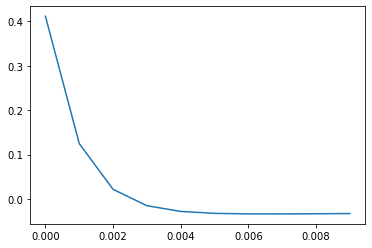

In [107]:
plt.plot(alphas, Ws)
#plt.ylim((0, 0.01))

$$J(W) = J_{old}(W) + alpha * (|w_1| + ... + |w_p|)$$

In [108]:
class LR_valid_L1:
    def __init__(self, num_features=1, optimizer=utils.GD(0.05), alpha=0):
        self.W = np.zeros((num_features, 1)) + 5
        self.optimizer = optimizer
        self.alpha = alpha
    
    def predict(self, X):
        y = X @ self.W
        return y
    
    def one_step_opt(self, X, y_true):
        grad_reg = self.alpha * np.sign(self.W)
        grad_reg[0, 0] = 0
        reg_loss = np.sum(self.alpha * np.abs(self.W))
        grads = - X.T @ (y_true - X @ self.W) / X.shape[0] + grad_reg
        self.W = self.optimizer.apply_grads(self.W, grads)
        loss = (y_true - self.predict(X)).T @ (y_true - self.predict(X)) / X.shape[0]
        return loss, grads, reg_loss
    
    def fit(self, X, y_true, X_valid=None, y_valid=None, grad_tol=0.0001, n_iters=10000):
        grad_norm = np.inf
        n_iter = 0
        losses = []
        valid_losses = []
        reg_losses = []
        while (grad_norm > grad_tol) and (n_iter < n_iters):
            loss, grads, reg_loss = self.one_step_opt(X, y_true)
            grad_norm = np.linalg.norm(grads)
            n_iter += 1
            losses.append(loss[0][0])
            valid_loss = (y_valid - self.predict(X_valid)).T @ (y_valid - self.predict(X_valid)) / X_valid.shape[0]
            valid_losses.append(valid_loss[0][0])
            reg_losses.append(reg_loss)
        return np.array(losses), np.array(valid_losses), np.array(reg_losses)
    
    def fit_closed_form(self, X, y_true, X_valid=None, y_valid=None):
        self.W = np.linalg.inv(X.T @ X) @ X.T @ y_true
        loss = (y_true - self.predict(X)).T @ (y_true - self.predict(X)) / X.shape[0]
        return loss

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


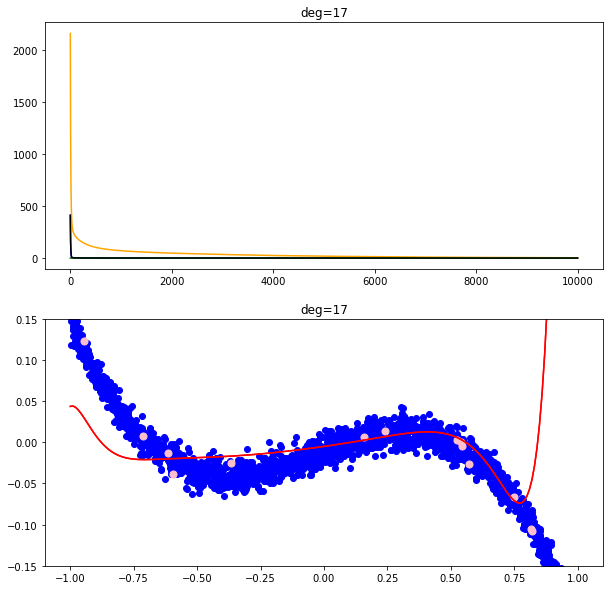

In [157]:
plt.figure(figsize=(10, 10))
terminal_losses = []
alphas = np.arange(0.01, 0.005, 0.001)
Ws = []
alpha = 0.003

#for alpha in alphas:

k = 17

x_poly = make_poly(x_small, k)
mu = np.mean(x_poly, axis=0)
std = np.std(x_poly, axis=0)
x_poly = (x_poly - mu) / std
x_poly[:, 0] = 1

x_valid = make_poly(x[100:1100], k)
x_valid = (x_valid - mu) / std
x_valid[:, 0] = 1
y_valid = y[100:1100]
lr = LR_valid_L1(num_features=x_poly.shape[1], alpha=alpha)
losses, valid_losses, reg_losses = lr.fit(x_poly, y_small, X_valid=x_valid, y_valid=y_valid)
terminal_losses.append(valid_losses[-1])
Ws.append(lr.W[2])
total_losses = losses + reg_losses

plt.subplot(2, 1, 1)
plt.plot(losses, color='blue')
plt.plot(valid_losses, color='orange')
plt.plot(reg_losses, color='green')
plt.plot(total_losses, color='black')
#plt.ylim((0, 0.005))
plt.title(f'deg={k}')

t_poly = make_poly(t, k)
y_pred = lr.predict(t_poly)
plt.subplot(2, 1, 2)

plt.plot(t[:, 1], y_pred, color='red')
plt.plot(t[:, 1], y_pred, color='red')
plt.scatter(x[8000:, 1], y[8000:], color='blue')
plt.scatter(x_small[:, 1], y_small, color='pink', s=50)
plt.ylim((-0.15, 0.15))
plt.title(f'deg={k}')
plt.show()


In [134]:
terminal_losses = []
alphas = np.arange(0.009, 0.01, 0.0001)
Ws = []

k = 17

x_poly = make_poly(x_small, k)
x_valid = make_poly(x[100:1100], k)
y_valid = y[100:1100]
for alpha in alphas:

    lr = LR_valid_L1(num_features=x_poly.shape[1], alpha=alpha)
    losses, valid_losses, reg_losses = lr.fit(x_poly, y_small, X_valid=x_valid, y_valid=y_valid)
    terminal_losses.append(valid_losses[-1])
    Ws.append(lr.W[2])
    total_losses = losses + reg_losses

